In [2]:
print('hi')
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA acceleration.")
else:
    print("CUDA is not available. You will suffer from very slow training without a GPU.")
    device = torch.device("cpu")


BATCH_SIZE = 64 
LEARNING_RATE = 0.0003
NUM_EPOCHS = 30
DATA_DIR = "data"
TRAIN_VAL_SPLIT = 0.9

hi
CUDA is not available. You will suffer from very slow training without a GPU.


In [3]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3),  # maybe dont use?
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)

train_size = int(TRAIN_VAL_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

val_dataset.dataset.transform = val_transforms 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Classes: {full_dataset.classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Classes: ['with_signal', 'without_signal']
Training samples: 71236
Validation samples: 7916


In [4]:
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    original_conv1 = model.conv1
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    with torch.no_grad():
        model.conv1.weight[:] = torch.mean(original_conv1.weight, dim=1, keepdim=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    return model

model = get_model().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

In [5]:
def train_model(model, train_loader, val_loader, epochs=20):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print('Training...')
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print('Validating...')
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = correct / total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
        
        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")
        
    return history

In [8]:
history = train_model(model, train_loader, val_loader, NUM_EPOCHS)
torch.save(model.state_dict(), "waterfall_resnet18_fullres.pth")
print("Model saved to waterfall_resnet18_fullres.pth")

Epoch 1/10
Training...


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
model.load_state_dict(torch.load("model_epoch_3.pth", map_location=torch.device('cpu')))

# get 1000 random samples from the validation set and predict their classes
model.eval()
import random
random_indices = random.sample(range(len(val_dataset)), 1000)
sampled_images = []
sampled_labels = []
for idx in random_indices:
    img, label = val_dataset[idx]
    sampled_images.append(img)
    sampled_labels.append(label)
sampled_images = torch.stack(sampled_images).to(device)
with torch.no_grad():
    outputs = model(sampled_images)
    _, predicted = torch.max(outputs, 1)
predicted = predicted.cpu().numpy()
sampled_labels = np.array(sampled_labels)

# Calculate accuracy
accuracy = np.mean(predicted == sampled_labels)
print(f"Accuracy on 1000 random validation samples: {accuracy:.4f}")

Accuracy on 1000 random validation samples: 0.9010


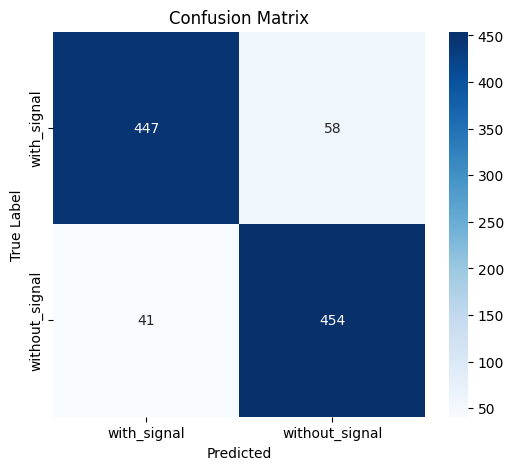

In [8]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(sampled_labels, predicted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

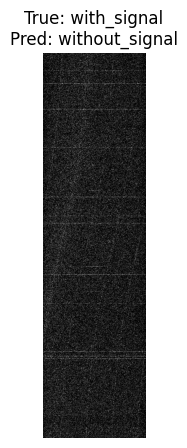

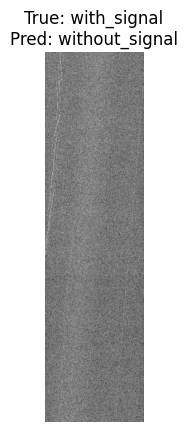

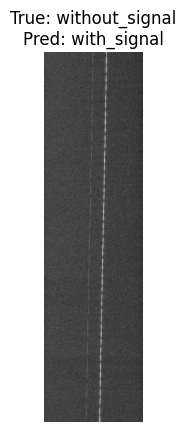

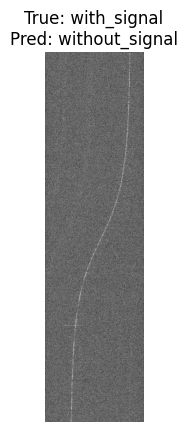

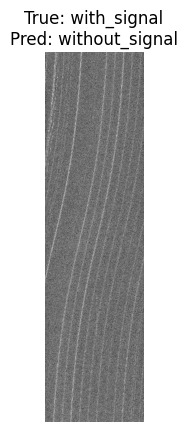

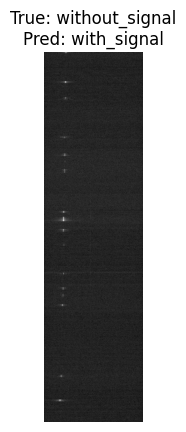

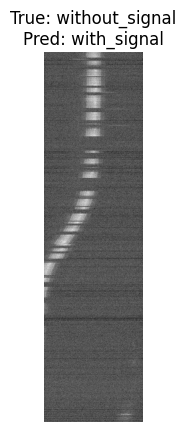

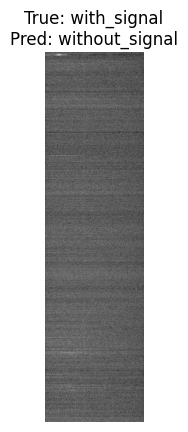

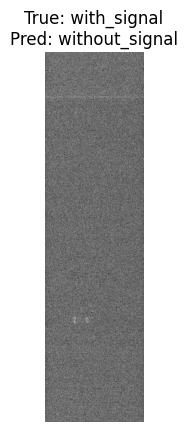

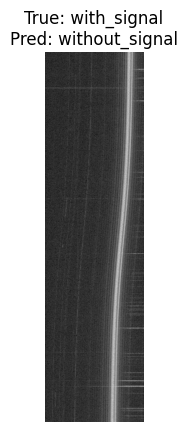

In [10]:
# Show misclassified images 
misclassified_indices = np.where(predicted != sampled_labels)[0]
num_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(15, 5))
for i in range(num_to_show):
    idx = misclassified_indices[i]
    img = sampled_images[idx].cpu().squeeze().numpy()
    true_label = full_dataset.classes[sampled_labels[idx]]
    pred_label = full_dataset.classes[predicted[idx]]
    
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
    plt.show()